In [3]:
!pip install ultralytics

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   -------------------- ------------------- 0.5/1.0 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 4.0 MB/s eta 0:00:00
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)

   ---------------------------------------- 0/4 [py-cpuinfo]
   ---------- ----------------------------- 1/4 [opencv-python]
   ---------- ----------------------------- 1/4 [opencv-python]
   ---------- ----------------------------- 1/4 [opencv-python]
   ---------- ----------------------------- 1/4 [opencv-python]
   ---------- ----------------------------- 1/4 [opencv-python]
   -------------------- ------------------- 2/4 [ultralytics-thop]
   ------------------------------ --------- 3/4 [ultralytics]
   ------------------------------ --------- 3/4 [ultralytics]
   ------------------------------ --------- 3/4 [ultral


image 1/1 d:\downloads\temp_image.jpg: 544x640 1 banana, 1 apple, 1 broccoli, 1 carrot, 168.5ms
Speed: 3.2ms preprocess, 168.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)
Predicted Ingredients: ['broccoli', 'banana', 'carrot', 'apple']


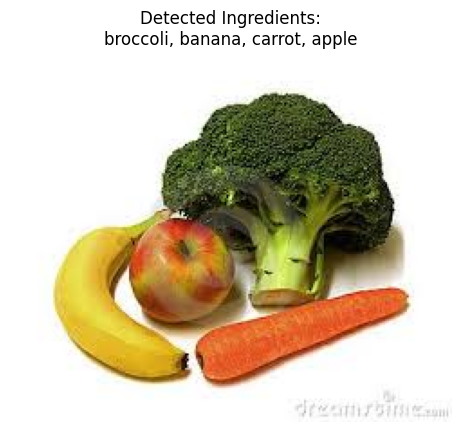


Recipes Found:

Recipe 1: Cider Roasted Carrot and Apple Fall Side Dish
Image: https://img.spoonacular.com/recipes/639397-312x231.jpg
Other required ingredients: apple cider, rosemary, honey

Recipe 2: Broccoli, Carrot, and Pepper Upma
Image: https://img.spoonacular.com/recipes/636231-312x231.jpg
Other required ingredients: chilli, peppers, lime

Recipe 3: Braised Carrots
Image: https://img.spoonacular.com/recipes/635807-312x231.jpg
Other required ingredients: rosemary, clv garlic, lemon zest, onion

Recipe 4: Copycat Panera Broccoli Cheddar Cheese Soup
Image: https://img.spoonacular.com/recipes/640038-312x231.jpg
Other required ingredients: butter, chicken broth, half and half, sharp cheddar cheese

Recipe 5: Chilled Swiss Oatmeal
Image: https://img.spoonacular.com/recipes/638604-312x231.jpg
Other required ingredients: old-fashioned oatmeal, vanilla yogurt, milk, cranberry, walnuts


In [ ]:
#Importing Libraries
from ultralytics import YOLO
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#for google drive
from PIL import Image
from io import BytesIO
#Loading the YOLO model
model = YOLO("yolov10s.pt")
#Defining Spoonacular API key
api_key = '19d094d105d340e7910fb7587fbf00fb'
#Defining food classes to look for
food_classes = ["apple", "banana", "orange", "broccoli", "carrot"]
#Getting recipes from Spoonacular API
def get_recipes_from_ingredients(ingredients, api_key=api_key, number=5):
    if not ingredients:
        print("No valid ingredients to search recipes.")
        return []
    base_url = "https://api.spoonacular.com/recipes/findByIngredients"
    params = {
        "ingredients": ",".join(ingredients),
        "number": number,
        "ranking": 1,
        "ignorePantry": True,
        "apiKey": api_key
    }
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        recipes = []
        for r in data:
            missed = [item['name'] for item in r.get('missedIngredients', [])]
            recipe = {
                "title": r["title"],
                "image": r["image"],
                "id": r["id"],
                "missing_ingredients": missed
            }
            recipes.append(recipe)
        return recipes
    except requests.exceptions.RequestException as e:
        print(f"API request failed: {e}")
        return []
#Predicting ingredients from image using YOLO
def predict_image(image_path, model, food_classes, confidence_threshold=0.5, save_output=True):
    results = model(image_path)
    if save_output:
        results[0].show()
        results[0].save(filename='food_detected.jpg')
    detected_ingredients = set()
    for box in results[0].boxes:
        cls_id = int(box.cls[0])
        class_name = results[0].names[cls_id]
        confidence = float(box.conf[0])
        if class_name in food_classes and confidence > confidence_threshold:
            detected_ingredients.add(class_name)
    return list(detected_ingredients)
#Wrapper function to predict and fetch recipes
def predict_and_get_recipes(image_path, model, food_classes, api_key, number_of_recipes=5, show_image=True):
    predicted_ingredients = predict_image(image_path, model, food_classes)
    print("Predicted Ingredients:", predicted_ingredients)
    if not predicted_ingredients:
        print("No confident ingredients detected. Try another image.")
        return []
    if show_image:
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Detected Ingredients:\n" + ", ".join(predicted_ingredients))
        plt.show()
    #Fetching recipes
    recipes = get_recipes_from_ingredients(
        ingredients=predicted_ingredients,
        api_key=api_key,
        number=number_of_recipes
    )
    #Printing  results
    if not recipes:
        print("No recipes found using these ingredients.")
        return []
    print("\nRecipes Found:")
    for i, r in enumerate(recipes, 1):
        print(f"\nRecipe {i}: {r['title']}")
        print(f"Image: {r['image']}")
        if r['missing_ingredients']:
            print(f"Other required ingredients: {', '.join(r['missing_ingredients'])}")
        else:
            print("No missing ingredients!")
    return recipes
# DOWNLOADING IMAGE FROM GOOGLE DRIVE
file_id = "1euYdmsvwtv93O_lWILz8I-t7UHAal8GD"
image_url = f"https://drive.google.com/uc?export=download&id={file_id}"
response = requests.get(image_url)
if response.status_code == 200:
    with open("temp_image.jpg", "wb") as f:
        f.write(response.content)
    image_path = "temp_image.jpg"
    predict_and_get_recipes(image_path, model, food_classes, api_key)
else:
    print("Failed to download image from Google Drive.")